# Flood mapping in Wales during 2020 winter

## Background

### Floodings in Wales during 2020

In 2020, Wales experienced some of the largest flooding on record. 
The sequencing, duration and severity of the rainfall in the catchment areas of Wales during February was of such intensity that many river levels reacted extremely quickly, reaching record levels and flows.
Records show 288mm of rain fell on average across Wales in February, but with some areas receiving up to four times the long-term monthly average.


For River Wye, Flood Warnings were issued on:
- 15 Feb (evening) - 17 Feb 2020
- 24 Feb - 25 Feb 2020
- 29 Feb - 01 Mar 2020
- 10 Mar 2020

For River Usk, Flood Alerts were issued on:
- 09 Feb - 10 Feb 2020
- 15 Feb (evening) - 18 Feb 2020
- 24 Feb - 25 Feb 2020
- 28 Feb  (evening) - 01 Mar 2020

For River Severn, Flood Warnings were issued on:
- 09 Feb - 10 Feb 2020
- 16 Feb - 17 Mar 2020
- 23 Feb - 25 Mar 2020
- 29 Feb 2020
- 10 Mar 2020

For River Dee, Flood Alerts were issued on:
- 09 Feb - 11 Feb 2020
- 13 Feb - 04 Mar 2020


![Image of Yaktocat](https://i.guim.co.uk/img/media/4c458a2a9007cb1d60a20a0cae70ab3439ed99d4/0_27_4314_2588/master/4314.jpg?width=620&quality=45&auto=format&fit=max&dpr=2&s=2371d95503d9d0f28a6c8206937f70ca)
An aerial view of the flooded Welsh town of Crickhowell, where the River Usk burst its banks as a result of Storm Dennis. Photograph: Christopher Furlong/Getty Images

## Description
This notebook demonstrates how floods can be quickly mapped/monitored, using Sentinel-1 Synthetic Aperture Radar (SAR) satellite sensor, from the newly developped Wales Data Cube. 

Synthetic Aperture Radar (SAR) data have the advantage of operating at wavelengths not impeded by cloud cover or a lack of illumination and can acquire data over a site during day or night time under all weather conditions. Sentinel-1, with its C-SAR instrument, offers reliable repeated wide area monitoring.

Living Wales project has allowed generation of national annual land cover maps (2017-2021), but is also actively involved in the development of a new digital infrastructure (incl. Open Data Cube technology) for Wales that provides Analysis Ready Data, which are satellite data that have been processed to a minimum set of requirements and organized into a form that allows immediate analysis with minimum additional user effort, and derived products in Near-Real Time.

This notebook uses the Near_real Time Analysis Ready Sentinel-1 Data, as well as a python library for flood mapping, developed and provided by the Living Wales project.


Topics include: 

1. Querying data for an area and period of interest (i.e., 01 Feb - 15 Mar 2020)
2. Loading data from datacube
3. Mapping Sentinel-1 signal for each date of the period of interest
4. Mapping flooded areas on daily basis
5. Mapping the progression of flood waters during the period of interest
6. Calculating water frequency


### Jupyter Notebooks
#### Running (executing) a cell
Jupyter Notebooks allow code to be separated into sections that can be executed independent of one another.
These sections are called "cells".

Python code is written into individual cells that can be executed by placing the cursor in the cell and typing `Shift-Enter` on the keyboard or selecting the &#9658; "Run" button in the ribbon at the top of the notebook.
These options will run a single cell at a time.

To automatically run all cells in a notebook, navigate to the "Cell" tab of the menu bar at the top of JupyterLab and select "Run All" (or the option that best suits your needs).
When a cell is run, the cell's content is executed.
Any output produced from running the cell will appear directly below it.

Run the cell below as a test:

In [1]:
print("I ran a cell!")

I ran a cell!


#### Cell status
The `[ ]:` symbol to the left of each Code cell describes the state of the cell:

* `[ ]:` means that the cell has not been run yet.
* `[*]:` means that the cell is currently running.
* `[1]:` means that the cell has finished running and was the first cell run. The number indicates the order that the cells were run in.

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

In [2]:
import sys
sys.path.append("..")

import datacube
import matplotlib.pyplot as plt
from time import time as time
import warnings
warnings.filterwarnings("ignore")

# Import Living Wales 'flooding' Python library
import wales_utils.data_cube_utilities.flooding as flooding

### Connect to the datacube
Connect to the datacube so we can access Living Wales Analysis Ready Data. 

In [3]:
dc = datacube.Datacube()

### Query an area and period
#### Area :  Please choose one of the four rivers, enter the name in the cell below and "Run" it
- 'wye'
- 'severn'
- 'dee'
- 'usk'


In [4]:
#####################
#  ENTER RIVER NAME #
#####################

river = 'wye'

In [5]:
# select the above site
site = flooding.select_flooded_site(river)

Chosen area: River Wye


#### Period
For this example, period of interest has been fixed to 01 Feb to 15 Mar 2020, which is the period of issued Flood Warnings/Alerts.

In [6]:
start_date = '2020-02-01'
end_date = '2020-03-15'

print("Analysed period: " + start_date + " to " + end_date)

Analysed period: 2020-02-01 to 2020-03-15


### Loading data from datacube 

#### Load data

In [7]:
# Preparing query for datacube
start_time = time()
query = flooding.query_site_period(site, start_date, end_date)

# Let's load and clean a demo dasatet
dataset_in = dc.load(**query,
                    dask_chunks={'x': 1000, 'y': 1000})

# define nodata
dataset_in = dataset_in.where(dataset_in != 0)
# drop dates with only nodata for the area of interest
dataset_in = dataset_in.dropna('time', how='all')
# rename x and y with explicit names
dataset_in = dataset_in.rename({'x': 'longitude', 'y': 'latitude'})

# group images by YYYY-MM-DD
S1_dataset = dataset_in.groupby(dataset_in.time.dt.strftime("%Y-%m-%d")).mean("time")
S1_dataset = S1_dataset.rename({'strftime': 'date'})

print("Datacube ready")
print("Took only " + str(round(time()-start_time,2)) + " seconds to load all the requested data from datacube.")

Datacube ready
Took only 2.48 seconds to load all the requested data from datacube.


#### Have a look at the dataset structure

In [8]:
S1_dataset

<xarray.Dataset>
Dimensions:      (date: 27, latitude: 582, longitude: 669)
Coordinates:
  * latitude     (latitude) float64 2.488e+05 2.488e+05 ... 2.43e+05 2.43e+05
  * longitude    (longitude) float64 3.306e+05 3.307e+05 ... 3.373e+05 3.373e+05
    spatial_ref  int32 27700
  * date         (date) object '2020-02-05' '2020-02-07' ... '2020-03-15'
Data variables:
    VH           (date, latitude, longitude) float32 dask.array<chunksize=(1, 582, 669), meta=np.ndarray>
    VV           (date, latitude, longitude) float32 dask.array<chunksize=(1, 582, 669), meta=np.ndarray>

#### Map Sentinel-1 VH backscatter (decibel) for each date of the period of interest

Plotting ...
(Please wait until images appear. This may take a few seconds)


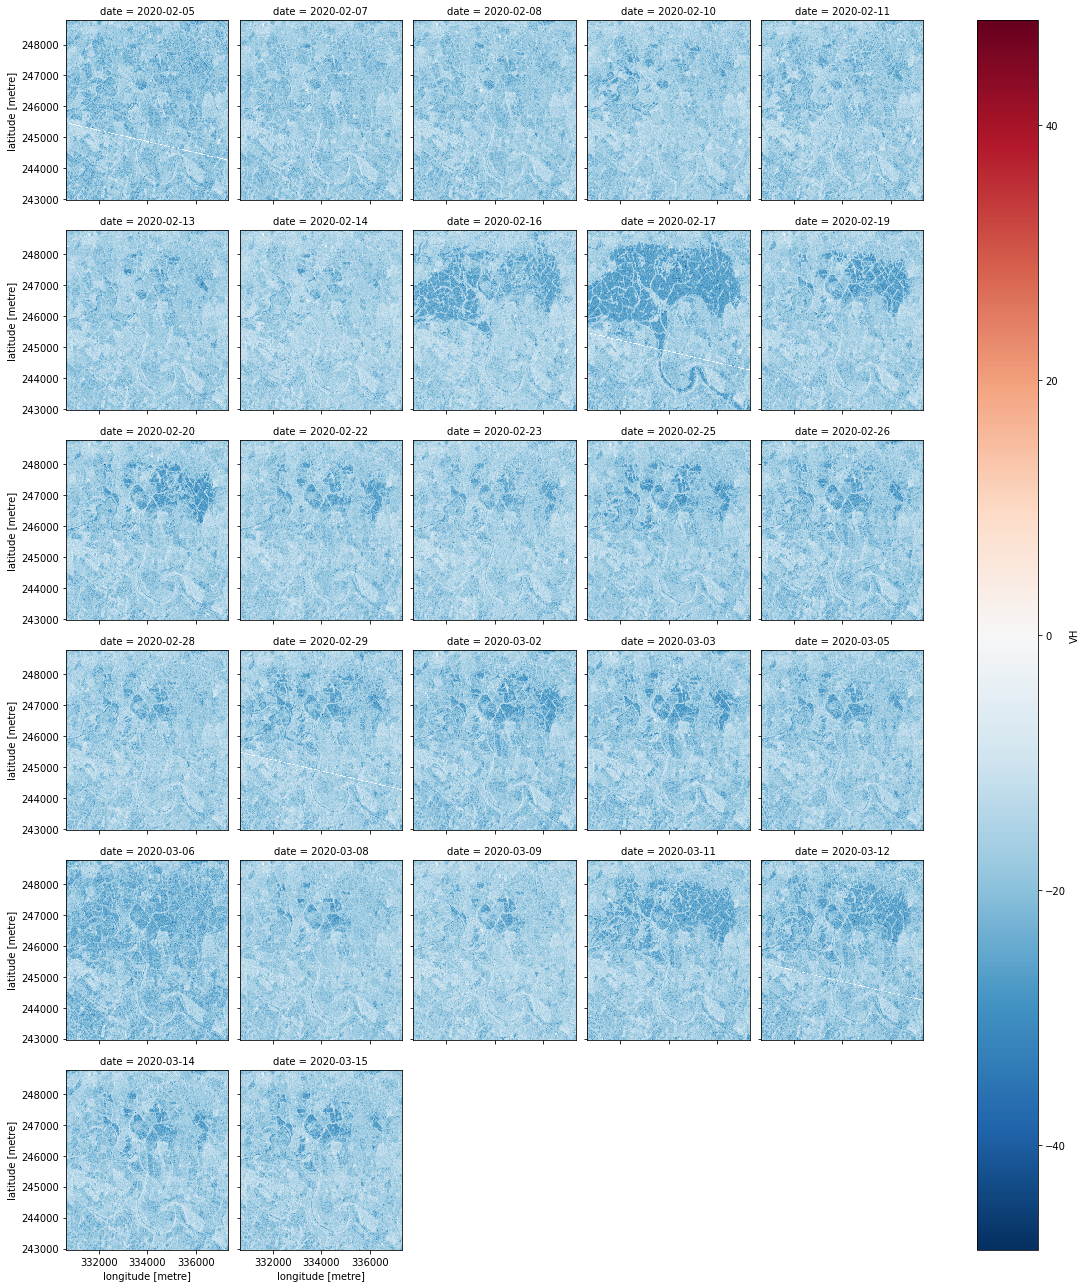

In [9]:
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds)")

S1_dataset.VH.plot(col='date', col_wrap=5)

### Mapping flooded areas
In this section, we will create a map of flood water extent for each date of the period of interest using the Living Wales python library, and visualise them.

Plotting ...
(Please wait until images appear. This may take a few seconds)


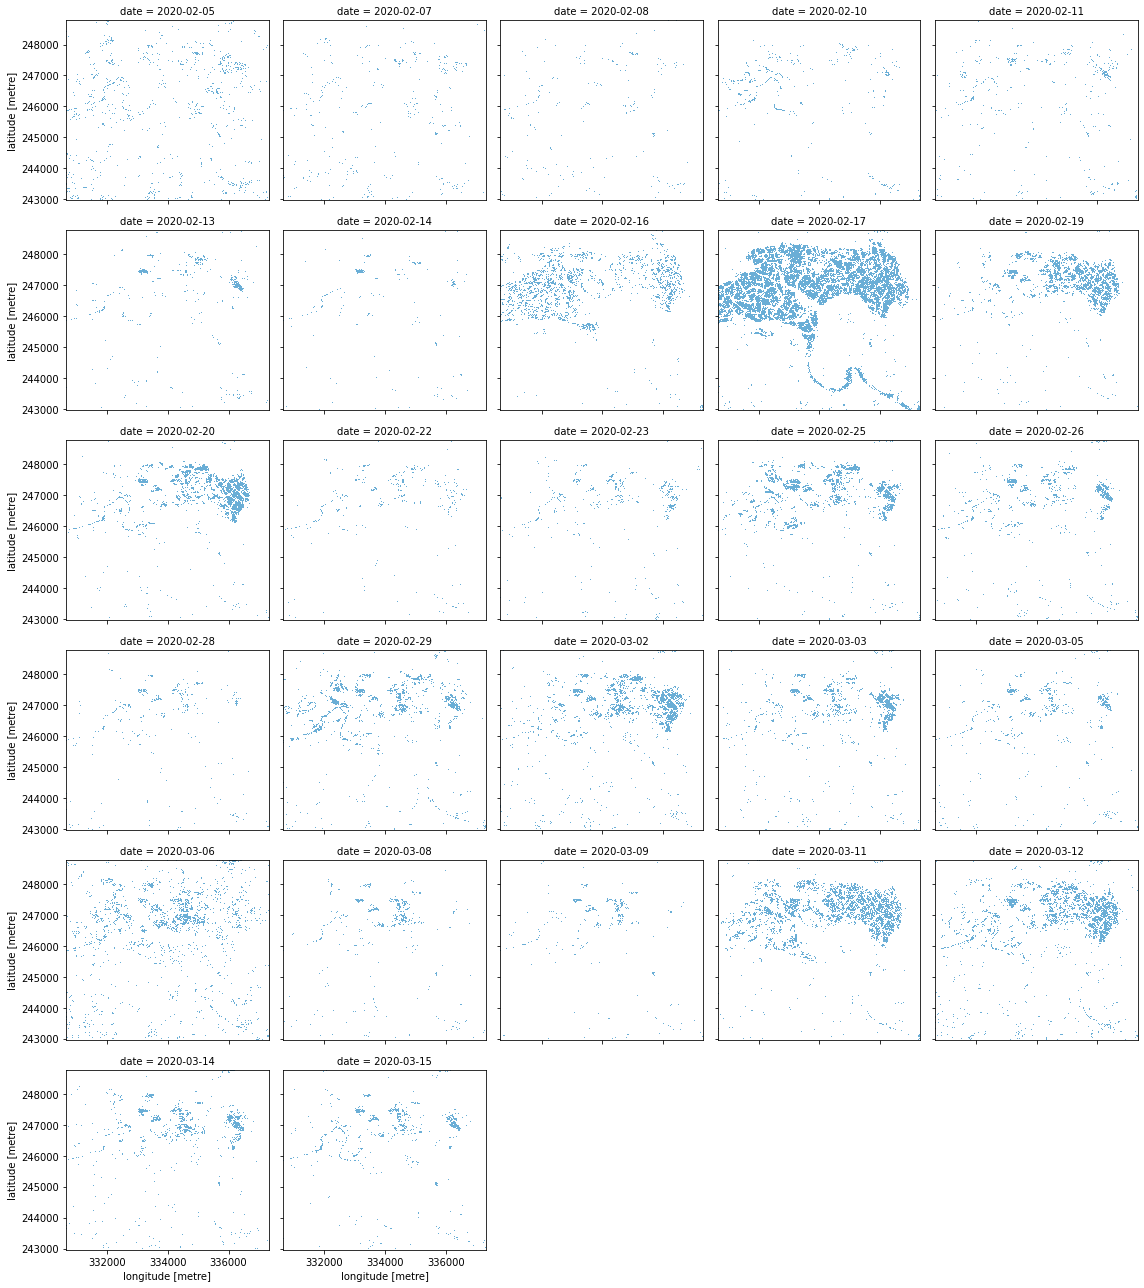

In [10]:
# Map flooded areas for each available Sentinel-1 scene
floods = flooding.flood_mapping(S1_dataset)


# Visualise flooded areas for each date
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds)")

floods.plot(col='date', col_wrap=5, add_colorbar=False, cmap="Blues")

### Mapping progression of flood waters

In this scetion, we will be mapping the progression of the flood waters through the landscape in Near-Real Time during the whole period. This allows sensing of (1) newly flooded areas, (2) areas where flood waters have receded and (3) areas still flooded, for each consecutive date.


- RED: newly flooded areas since previous satellite imagery
- ORANGE: areas remaining flooded
- BLUE: areas where flood waters have receded since previous satellite imagery

Plotting ...
(Please wait until images appear. This may take a few seconds)


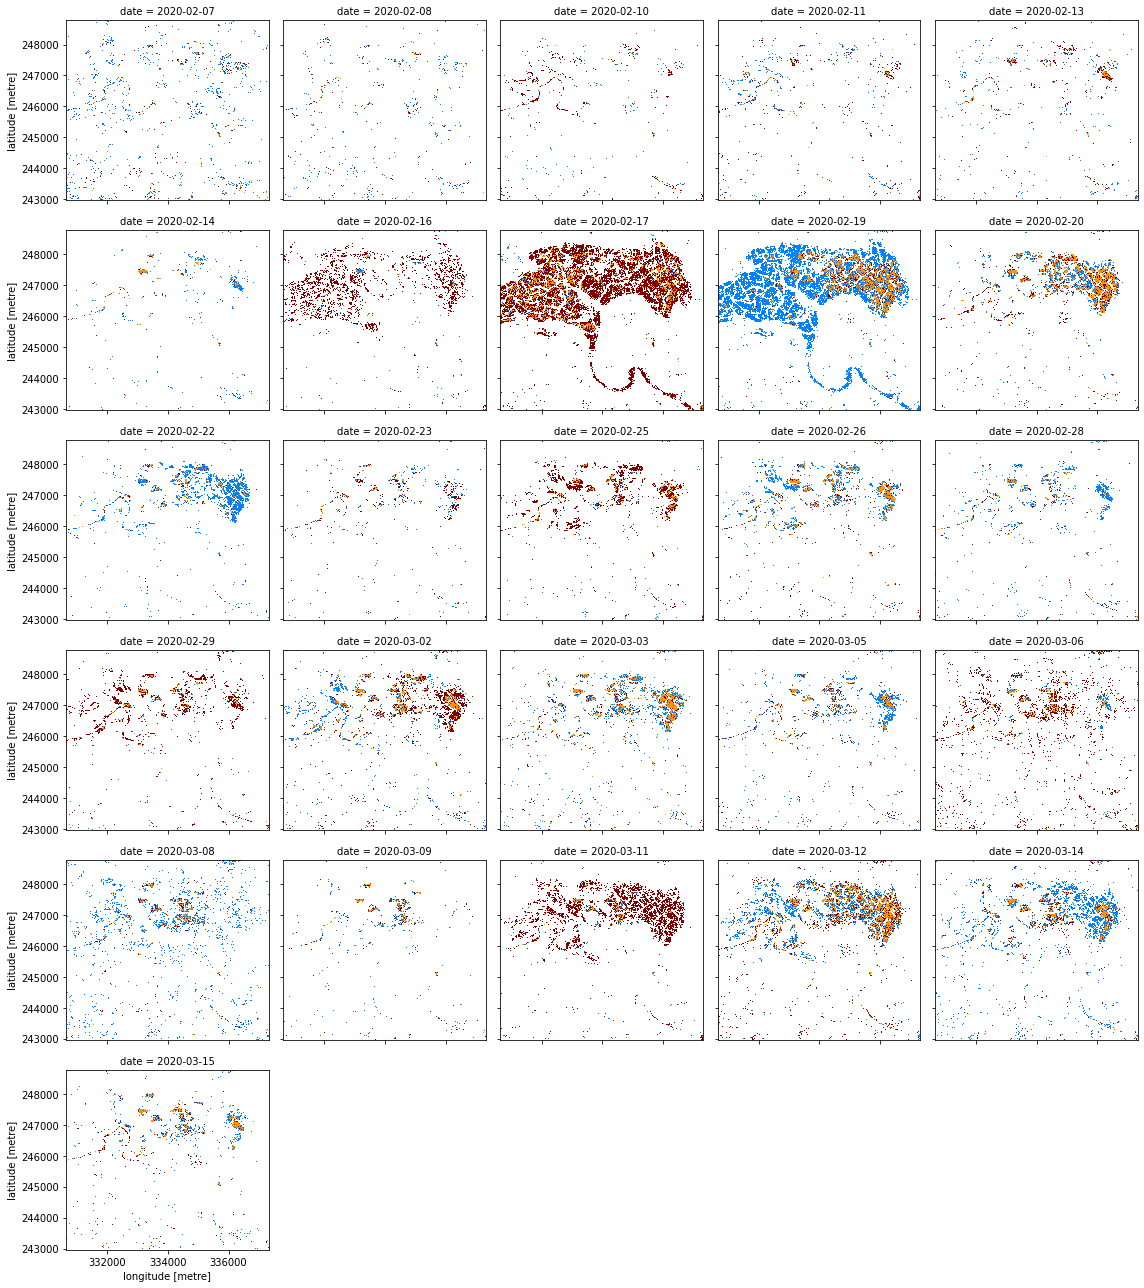

In [11]:
# Calculate water progression between each date of the studied period 
water_changes = flooding.flood_progression(floods)


# Visualise water progression between each date of the studied period 
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds)")

water_changes.plot(col='date', col_wrap=5, cmap="jet", add_colorbar=False)

### Calculate water frequency during February 2020
In this section, we will calculate how frequently each pixel was observed as wet during February 2020, and plot the frequency map.

Plotting ...
(Please wait until images appear. This may take a few seconds)


Text(0.5, 1.0, 'Water frequency during February 2020')

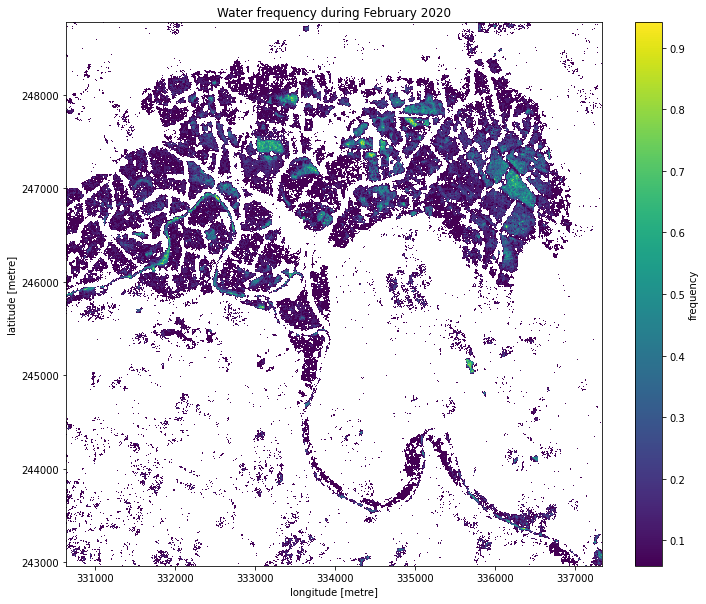

In [12]:
# Calculate water frequency during February 2020
frequency = flooding.flood_frequency(floods, '2020-02-01', '2020-02-29')


# Visualise water frequency during February 2020
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds)")

frequency.plot(figsize=(12,10))
plt.title('Water frequency during February 2020')